# NOTEBOOK NAME
Created by: Thomas Durand-Texte, 2023

# Import des packages et données
## import des packages

In [219]:
import os

import pickle
import time

import pandas as pd
import numpy as np
# import dask as dd
pd.set_option("display.max_columns", 200)
import datetime as dt
import scipy.stats as st

from sklearn import model_selection, metrics, preprocessing, linear_model, dummy

from sklearn.svm import LinearSVR, SVR
from sklearn import kernel_ridge
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns

cm = 1./2.54

## Paramètres graphiques et fonctions utiles

In [220]:
import subprocess

white_font = True
def set_theme( white_font=True ):
    """ set_theme( white_font=True ) """
    if white_font: wht, grey, blck = '0.84' , '0.5', 'k'
    else: wht, grey, blck = 'k', '0.5', '0.84'
    rc = { 'figure.facecolor':(0.118,)*3,
            'axes.labelcolor':wht,
            'axes.edgecolor':wht,
            'axes.facecolor':(0,0,0,0),
            'text.color':'white',
            'text.usetex':False,
            'text.latex.preamble':r'\usepackage[cm]{sfmath} \usepackage{amsmath}' ,
            'font.family': 'sans-serif' ,
            'font.sans-serif': 'DejaVu Sans' ,
            'xtick.color':wht,
            'ytick.color':wht,
            "axes.grid" : True,
            "grid.color": (0.7,)*3,
            "grid.linewidth": 0.4,
            "grid.linestyle": (10,5),
            'legend.edgecolor':'0.2',
            'legend.facecolor':(0.2,0.2,0.2,0.6),
            # 'legend.framealpha':'0.6',
            'pdf.fonttype':42,
            'savefig.format':'pdf',
            'savefig.transparent':True,
            'figure.dpi':150, # for better agreemet figsize vs real size
        }

    sns.set_theme( 'notebook' , rc=rc )
    return


def make_folder( path_folder ):
    path_folder = path_folder.__str__()
    try:
        if os.path.isdir( path_folder ) : return
        os.makedirs(path_folder)
    except OSError:
        pass
    return

def concat_folders(*args, **kwargs):
    """ concat_folders(*args, **kwargs)
        concatenate folders in args (strings) """
    sPath = ''
    for arg in args:
        if arg == '..': sPath = sPath[:sPath[:-1].rfind(os.sep)+1]
        else: sPath += arg
        if sPath[-1] != os.sep: sPath += os.sep
    return sPath

class Path(object):
    """ Path( s_in='', s_lim=None)
        create a path to the string s_in (default is current path)
        and stops after s_lim """
    n_Path = 0
    def __init__(self, s_in='', s_lim=None):
        """docstring."""
        if s_in == '': s_in = os.getcwd()
        if not s_lim is None:
            if s_lim in s_in:
                s_in = s_in[ :s_in.index( s_lim ) + len(s_lim) ]
        self.sPath = concat_folders(s_in)
        self.N = Path.n_Path
        Path.n_Path += 1

    def __add__(self, other):
        """ Path + str : return str """
        if isinstance(other, str): return self.sPath + other

    def __truediv__(self, other):
        """ Path / str : return path concatenated"""
        if isinstance(other, str): return Path(concat_folders(self.sPath, other))

    def __invert__(self):
        """ ~Path : return str of the path """
        return self.sPath

    def __str__(self):
        """ __str__ return str of the path """
        return self.sPath
    # __str__ #

    def makedir( self ):
        return make_folder( self )


def gs_opt( filename ):
    """ otpimisation of a pdf file with gosthscript """
    filenameTmp = filename.replace('.pdf', '') + '_tmp.pdf'
    gs = ['gs',
            '-sDEVICE=pdfwrite',
            '-dEmbedAllFonts=true',
            '-dSubsetFonts=true',             # Create font subsets (default)
            '-dPDFSETTINGS=/prepress',        # Image resolution
            '-dDetectDuplicateImages=true',   # Embeds images used multiple times only once
            '-dCompressFonts=true',           # Compress fonts in the output (default)
            '-dNOPAUSE',                      # No pause after each image
            '-dQUIET',                        # Suppress output
            '-dBATCH',                        # Automatically exit
            '-sOutputFile='+filenameTmp,      # Save to temporary output
            filename]                         # Input file

    subprocess.run(gs)                                      # Create temporary file
    subprocess.run( 'rm -f ' + filename, shell=True)            # Delete input file
    subprocess.run( 'mv -f ' + filenameTmp + " " + filename, shell=True) # Rename temporary to input file

def savefig( fig, savename, **kwargs ):
    """ savefig( fig, savename, **kwargs )
        Saves a figure with kwargs (fig.savefig( savename, **kwargs) ).
        A check is done first to determine if a folder has to be created according to savename.
        Finally, if the file is saved as .pdf, gosthscript optimisation is performed. """
    if os.sep in savename: make_folder( savename[:savename.rindex(os.sep)] )
    fig.savefig( savename, **kwargs )
    savename += '.pdf'
    if os.path.isfile( savename ): gs_opt( savename )


def image_size_from_width_and_shape( width: float, shape: tuple, ymargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return width, width*shape[0]/shape[1]+ymargin

def image_size_from_height_and_shape( height: float, shape: tuple, xmargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return height*shape[1]/shape[0]+xmargin, height


set_theme()
del set_theme

## Chargement des données

Affichage de l'arborescence

In [221]:
def print_listdir( path=None, level=0, exclude=[] ) :
    suffix = ''
    if level > 0:
        suffix = ' |-'* level
    vals = os.listdir( path )
    vals.sort()
    if path is None:
        path = ''
    for val in vals:
        if val in exclude: continue
        print( suffix, val)
        if os.path.isdir( path + val):
            print_listdir( path + val + '/', level+1 )

print_listdir( exclude=['.venv', 'ressources'] )

 Exploration_v0.ipynb
 Modelisation_energy.ipynb
 TODO
 data
 |- cleaned
 |- |- 2016_Building_Energy_Benchmarking.pkl
 |- |- 2016_Building_Energy_Benchmarking_annexe.pkl
 |- |- 2016_Building_Energy_Benchmarking_location.pkl
 |- |- 2016_Building_Energy_Benchmarking_usetype.pkl
 |- |- other_data.pkl
 |- source
 |- |- 2016_Building_Energy_Benchmarking.csv
 |- |- 2016_Building_Energy_Benchmarking.pkl
 devel
 |- Exploration_v0 (copy).ipynb
 |- Exploration_v0.ipynb
 |- Modelisation_energy_v0.ipynb
 |- regressor.ipynb
 install_packages_venv.sh


Chargement des données

In [222]:
path = 'data/cleaned/'
filename = '2016_Building_Energy_Benchmarking'
compression = 'gzip'

df = pd.read_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression )

df = pd.read_pickle( r'{:}{:}.pkl'.format(path, filename), compression=compression)
df_hotencoding_usetype = pd.read_pickle( r'{:}{:}_usetype.pkl'.format(path, filename), compression=compression)
df_hotencoding_location = pd.read_pickle( r'{:}{:}_location.pkl'.format(path, filename), compression=compression)
df_annexe = pd.read_pickle( r'{:}{:}_annexe.pkl'.format(path, filename), compression=compression)

print('df:', df.shape)
print('df_hotencoding_usetype:', df_hotencoding_usetype.shape)
print('df_hotencoding_location:', df_hotencoding_location.shape)
print('df_annexe:', df_annexe.shape)
print('df columns:', df.columns.tolist())

df: (1549, 11)
df_hotencoding_usetype: (1549, 18)
df_hotencoding_location: (1549, 13)
df_annexe: (1549, 7)
df columns: ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', '%GFABuilding(s)', 'SiteEUIWN(kBtu/sf)', '% SteamUse', '% Electricity', '% NaturalGas', 'Outlier', 'GHGEmissionsIntensity', 'AgeOfBuilding(s)']


In [223]:
to_drop = [ 'GHGEmissionsIntensity' ]

df.drop( columns=to_drop, inplace=True )

df = pd.concat( (df, df_hotencoding_location, df_hotencoding_usetype), axis=1 )
print('df shape:', df.shape)

sr_loc = df.isna().sum(1) == 0

df = df.loc[ sr_loc, :]

target = 'SiteEUIWN(kBtu/sf)'
y = df[target]
df.drop( columns=target, inplace=True )

print('df shape:', df.shape)
print('y shape:', y.shape)


df.head()

df shape: (1549, 41)
df shape: (1549, 40)
y shape: (1549,)


,NumberofBuildings,NumberofFloors,PropertyGFATotal,%GFABuilding(s),% SteamUse,% Electricity,% NaturalGas,Outlier,AgeOfBuilding(s),ballard,central,delridge,downtown,east,greater duwamish,lake union,magnolia / queen anne,north,northeast,northwest,southeast,southwest,data center,education,entertainment/public assembly,industrial,lifestyle center,medical,medical office,office,other,other - entertainment/public assembly,residential - hotel,restaurant,science,self-storage facility,services,store,utility,worship facility
0,1.0,12,88434,1.000000,0.277302,0.546060,0.176638,0,89,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,11,103566,0.854547,0.000000,0.386609,0.613391,0,20,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.809918,0.044629,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,41,956110,0.794252,0.297113,0.682307,0.020579,0,47,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,10,61320,1.000000,0.325913,0.407519,0.266567,0,90,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,18,175580,0.646885,0.000000,0.378802,0.621198,0,36,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.644776,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


<span style="color:red"> FAIRE UN TRANSFORMER AVEC PLUSIUERS MODES: </span>
- identiy
- log
- ... ?

call fit
out y.min(): 0.699999988
out y.min(): 0.699999988
call transform


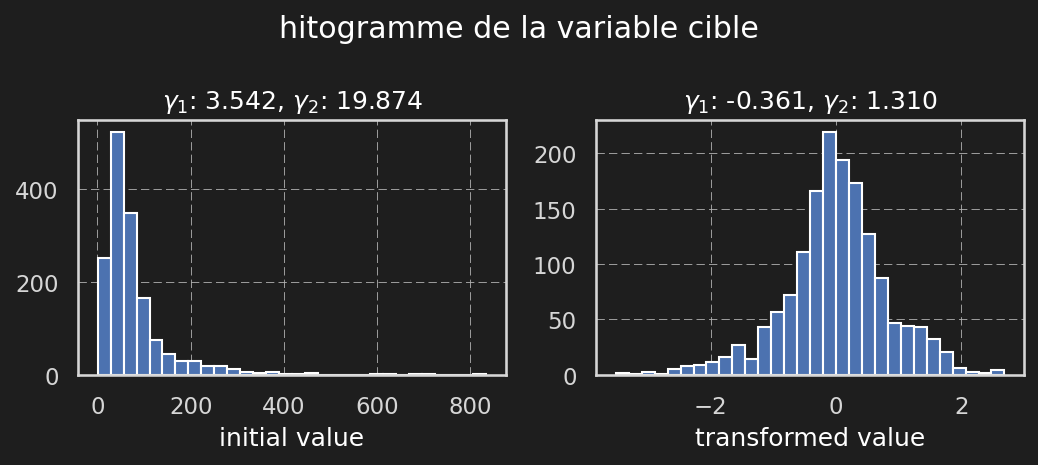

In [224]:
class TargetTransformer:
    def __init__(self ):
        self.cst = 0.
        self.coef = 1.
        return
    def get_dico_func(self):
        return {'func':self.transform, 'inverse_func':self.reverse }
    def fit( self, y ):
        # self.cst = 1.-y.min()
        # self.coef = 1. / ( y.var() )
        # self.cst = -y.mean() * self.coef
        self.cst = -np.log(y+1).mean()
        return self
    def transform(self, y ):
        # return (y+self.cst)**(1/6)
        # return y*self.coef + self.cst
        return np.log(y+1) + self.cst
    def reverse(self, y_transformed ):
        # return -self.cst + y_transformed**6
        # return (y_transformed-self.cst) * ( 1./ self.coef )
        return np.exp( y_transformed-self.cst ) -1.

# dict_transformer = TargetTransformer(y).get_dico_func()
# transformer = preprocessing.FunctionTransformer( check_inverse=True, **dict_transformer )


print('call fit')
print('out y.min():', y.values.min())
# transformers = {'y': transformer.fit(y.values.copy()) }
transformers = {'y': TargetTransformer().fit(y.values.copy()) }
print('out y.min():', y.values.min())
print('call transform')
y_transformed = transformers['y'].transform(y)

fig, axs = plt.subplots( ncols=2, figsize=(18*cm,8*cm) )
axs[0].hist( y, bins=30 )
axs[1].hist( y_transformed, bins=30 )

axs[0].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y), st.kurtosis(y) ) )
axs[1].set_title( r'$\gamma_1$: {:.3f}, $\gamma_2$: {:.3f}'.format( st.skew(y_transformed), st.kurtosis(y_transformed) ) )

axs[0].set_xlabel('initial value')
axs[1].set_xlabel('transformed value')

fig.suptitle('hitogramme de la variable cible')
fig.tight_layout()

In [225]:
df.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       '%GFABuilding(s)', '% SteamUse', '% Electricity', '% NaturalGas',
       'Outlier', 'AgeOfBuilding(s)', 'ballard', 'central', 'delridge',
       'downtown', 'east', 'greater duwamish', 'lake union',
       'magnolia / queen anne', 'north', 'northeast', 'northwest', 'southeast',
       'southwest', 'data center', 'education',
       'entertainment/public assembly', 'industrial', 'lifestyle center',
       'medical', 'medical office', 'office', 'other',
       'other - entertainment/public assembly', 'residential - hotel',
       'restaurant', 'science', 'self-storage facility', 'services', 'store',
       'utility', 'worship facility'],
      dtype='object')

In [226]:
X = df.values
features_X = df.columns.tolist()

i = df.columns.get_loc( 'PropertyGFATotal')
X[:,i] = np.log( X[:,i] )

# X = X + 1. - X.min(0).reshape(1, -1)


X_train, X_test, y_train, y_test = model_selection.train_test_split( X, y, random_state=0)
y_train, y_test = y_train.values, y_test.values

dico_y = {'train':y_train, 'test':y_test}

In [227]:
print('X', X.shape)
print( 'X_train:', X_train.shape )

X (1549, 40)
X_train: (1161, 40)


***
# Definitions

Définition des modèles

In [228]:
modeles = {
    'dummy median': (dummy.DummyRegressor( ), {'strategy':['median']}),
    'elastic net':( linear_model.ElasticNet(random_state=0), 
                        {'l1_ratio':np.geomspace(0.5, 0.99, 10),
                        'alpha':np.logspace(-5, 1, 20)} ),
    'linear SVR': ( LinearSVR( dual=False ),
                        {'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],
                        'C':np.logspace(-5, 10, 20) } ),
    'kernel ridge polynomial':( kernel_ridge.KernelRidge(kernel='polynomial'),
                        {'alpha':np.logspace(-4, -2, 10),
                        'degree':[1,2,3,4],} ),
    'kernel ridge rbf':( kernel_ridge.KernelRidge(kernel='rbf'),
                        {'alpha':np.logspace(-4, -2, 10),
                        'gamma':np.logspace(-4, -2, 10),}),
    'kernel SVR rbf': ( SVR(kernel='rbf'),
                        {'C':np.logspace(0, 4, 10),
                        'gamma':np.logspace(-5, -3, 10),} ),
    'random forest': ( RandomForestRegressor(),
                        {'n_estimators':[300, 400, 500],
                        'min_samples_split': [10, 20, 50],
                        'max_depth':[None, 5, 10]}),
    'light GBM': ( LGBMRegressor(),
                        {'n_estimators': [150, 200, 300],
                        'subsample': np.arange(0.1, 1.1, 0.1),
                        'learning_rate': [0.001, 0.01, 0.1, 1.0],
                        'max_depth': np.arange(2, 11, 2),} ),
}

# pour gagner en vitesse pour les premier essais
# modeles.pop( 'random forest' )
# modeles.pop( 'light GBM' )

Fonctions

In [240]:
def log_transfrom( x ):
    return np.log( x + ( 1. - min([0, x.min()]) ) )

def print_coefs( coefs, features ):
    n_features_0 = len( features )

    print('coefficients linear:')
    print(coefs[:n_features_0])

    if len( coefs ) > n_features_0:
        print('coefficients non-linear:')
        print(coefs[n_features_0:])

    print('linear coefs == 0 for :') #, np.array(features)[ coefs[:n_features_0+1] == 0. ])
    print('[', end='')
    for feature in np.array(features)[ coefs[:n_features_0] == 0. ]:
        print( f"'{feature}', ", end='')
    print(']')

    if len( coefs ) > n_features_0+1:
        print('non-linear coefs == 0 for :', np.array(features[1:])[ coefs[n_features_0+1:] == 0. ])

def histogram_per_coef( X, coefs, features ):
    y = (X @ coefs.reshape(-1,1)).ravel()
    for xi, coef, feature in zip( X.transpose(), coefs, features):
        fig, ax = plt.subplots( figsize=(12*cm,8*cm))
        ax.hist( xi*(coef*100)/y, bins=50 )
        ax.set_ylabel('count')
        ax.set_xlabel('influence sur la cible (%)')
        ax.set_title(feature)

def plot_results( label, dico_results ):

    # argsort = y_test.argsort()
    # fig, ax = plt.subplots( figsize=(12*cm,8*cm) )
    # ax.plot( y_test[argsort], 'r', label='data' )
    # ax.plot( y_pred[argsort], 'bo', markersize=2, label=label )
    # ax.legend()
    # ax.set_xlabel('sample')

    fig, axs = plt.subplots( ncols=2, nrows=2, figsize=(20*cm,14*cm) )
    fig.suptitle( label )

    for i, dataset in enumerate( ['train', 'test'] ):
        y_pred = dico_results[label][ f'y_pred {dataset}' ]
        y = dico_y[dataset]
        ax = axs[0][i]
        ax.set_title( f'{dataset} set')
        ax.set_ylabel( 'prediction ' )
        ax.set_xlabel( 'target' )
        ax.plot( y, y_pred, 'bo', markersize=2 )
        xy_optim = [y.min(), y.max()]
        ax.plot( xy_optim, xy_optim, 'r', label='optimal fit' )
        # ax.legend()

        ax = axs[1][i]
        ax.hist( y_pred-y, bins=60 )
        ax.set_xlabel('Residual')
    fig.tight_layout()
    return

def model_to_results( name, model, training_time, dico_results ):
    dico_results[name] = {'y_pred test': model.predict(dico_X['test']),
                        'y_pred train': model.predict(dico_X['train']),
                        'training time': training_time,
                        'model':model }

def print_results0( dico_results ):
    scores = {
        'RMSE': lambda y_true,y_pred: np.sqrt(metrics.mean_squared_error(y_true,y_pred)),
        'R2 score': metrics.r2_score,
        }
    # index = pd.MultiIndex.from_tuples( [('', 'training time (sec.)')]
    #                                     + [('train',score) for score in scores]
    #                                     + [('test',score) for score in scores] )
    
    index = pd.MultiIndex.from_tuples( [('', 'training time (sec.)')]
                    + [(score,dataset) for score in scores for dataset in ['train', 'test'] ] )
    
    df_results = pd.DataFrame( index=index )
    for (name, results) in dico_results.items():
        # y_pred_train = dico_results[name]['y_pred train']
        # y_pred_test = dico_results[name]['y_pred test']
        df_results[name] = [results['training time']] \
            + [ score(dico_y[dataset], dico_results[name][ f'y_pred {dataset}']) for score in scores.values() for dataset in ['train', 'test'] ]
                        # + [ score(y_train_transformed, y_pred_train) for score in scores.values()] \
                        # + [ score(y_test_transformed, y_pred_test) for score in scores.values()]
    
    display( df_results.round(2) )

In [230]:
def train_modeles( y_transformer=None ):
    dico_results = {}
    for name, (model, param_grid) in modeles.items():
        model = train_model( name, model, param_grid, dico_results, y_transformer=y_transformer )
    return dico_results


def print_y_describe():
    print('y:')
    columns = pd.MultiIndex.from_tuples( [('raw', 'train'), ('raw', 'test'), 
                                        ('transformed', 'train'), ('transformed', 'test')] )
    describe = pd.Series(y_train).describe()
    tmp = pd.DataFrame( index=describe.index, columns=columns )

    tmp[ 'raw', 'train' ] = describe
    describe = pd.Series(y_test).describe()
    tmp[ 'raw', 'test' ] = describe
    describe = pd.Series(y_train_transformed).describe()
    tmp[ 'transformed', 'train' ] = describe
    describe = pd.Series(y_test_transformed).describe()
    tmp[ 'transformed', 'test' ] = describe

    display( tmp.round(2).T )
    return

def print_results( dico_results ):
    print_results0( dico_results )
    for name in modeles:
        model = dico_results[name]['model']
        print('\n\n|' + 20*'-' + '|\nModèle : {:}'.format(name) )
        print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
        print(model.best_params_)
        plot_results( name, dico_results )
    return

def train_model( model_name, model, param_grid, dico_results, score='r2', y_transformer=None ): 
    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    modelCV = model_selection.GridSearchCV(
        model, # modèle
        param_grid,     # hyperparamètres à tester
        cv=5,           # nombre de folds de validation croisée
        scoring=score,   # score à optimiser
        n_jobs=-1
    )

    t0 = time.time()
    modelCV.fit(dico_X['train'], dico_y['train'] )

    model_to_results( model_name, modelCV, time.time()-t0, dico_results )

    return modelCV

***
# Modélisations

In [231]:
import warnings

## Données brutes

In [232]:
dico_X = {'train':X_train, 'test':X_test}
dico_y = {'train':y_train, 'test':y_test}

results_0 = train_modeles()

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.371e+06, tolerance: 5.590e+02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e+06, tolerance: 5.988e+02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Pro

y:


count   mean    std   min    25%    50%    75%     max
raw         train  1161.0  78.22  76.13  0.70  37.50  56.80  87.90  834.40
            test    388.0  76.85  78.66  1.50  34.05  53.65  88.08  694.70
transformed train  1161.0   0.00   0.81 -3.53  -0.41   0.00   0.43    2.67
            test    388.0  -0.05   0.86 -3.14  -0.50  -0.05   0.43    2.49

dummy median  elastic net  linear SVR  \
         training time (sec.)          0.01         3.07        0.29   
RMSE     train                        79.05        58.54       58.53   
         test                         81.07        57.08       56.95   
R2 score train                        -0.08         0.41        0.41   
         test                         -0.07         0.47        0.47   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                     4.54             12.99   
RMSE     train                                   58.52             55.25   
         test                                    57.01             62.19   
R2 score train                                    0.41              0.47   
         test                                     0.47              0.37   

                               kernel SVR rbf  random forest  light GBM  
         training time (sec.)            8.92          51.75      49.62  
RMSE     train                          66.59          45.54      57.76  
         test                           73.71          53.24      68.98  
R2 score train                           0.23           0.64       0.42  
         test                            0.12           0.54       0.23



|--------------------|
Modèle : dummy median
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'strategy': 'median'}


|--------------------|
Modèle : elastic net
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.000379269019073225, 'l1_ratio': 0.7307755339398913}


|--------------------|
Modèle : linear SVR
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 127.42749857031347, 'loss': 'squared_epsilon_insensitive'}


|--------------------|
Modèle : kernel ridge polynomial
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.002154434690031882, 'degree': 1}


|--------------------|
Modèle : kernel ridge rbf
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.0001, 'gamma': 0.0001}


|--------------------|
Modèle : kernel SVR rbf
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 10000.0, 'gamma': 0.001}


|--------------------|
Modèle : random forest
Meilleur(s) hyperparamètre(s) sur le jeu d'entraîne

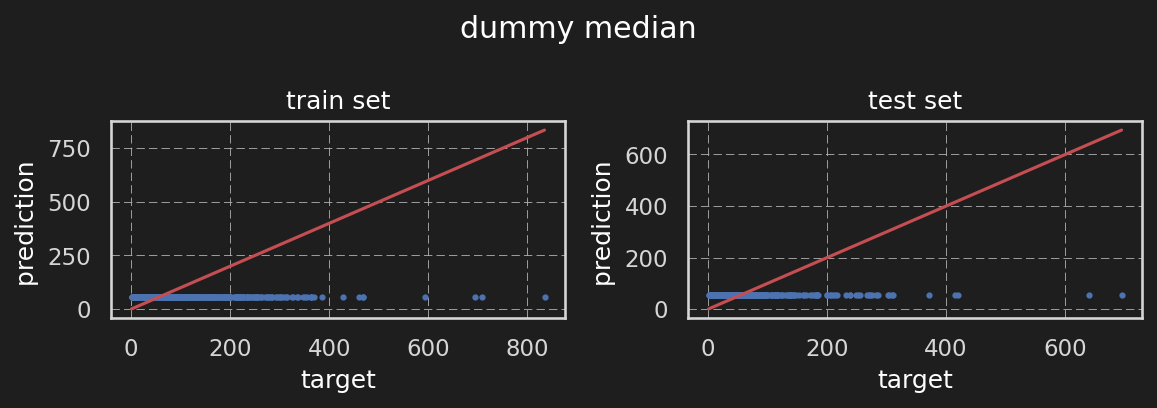

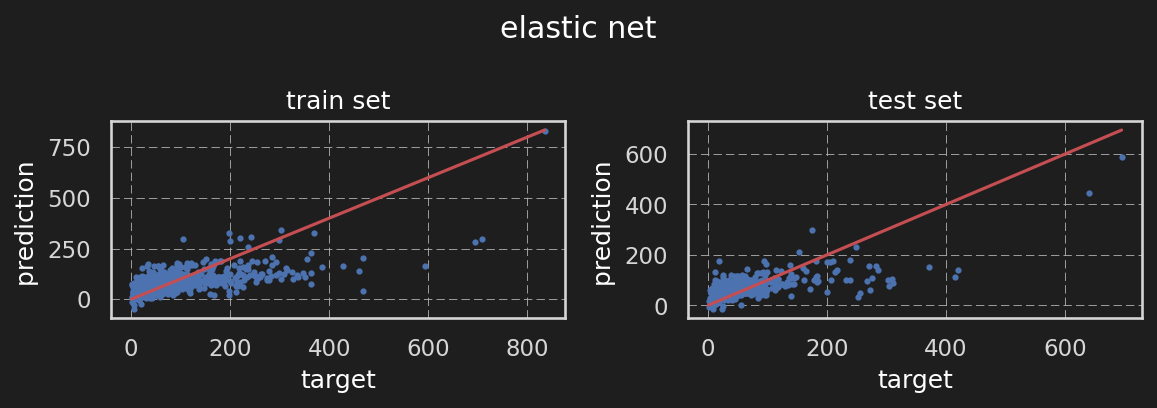

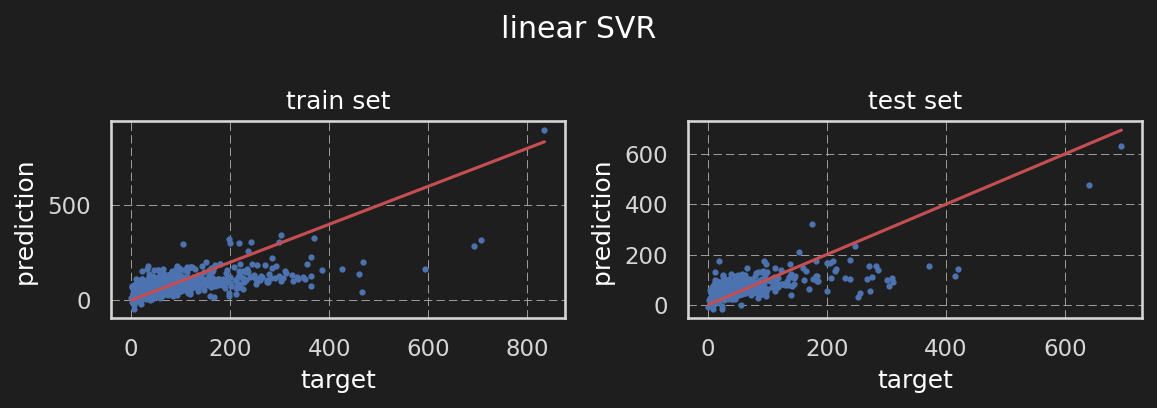

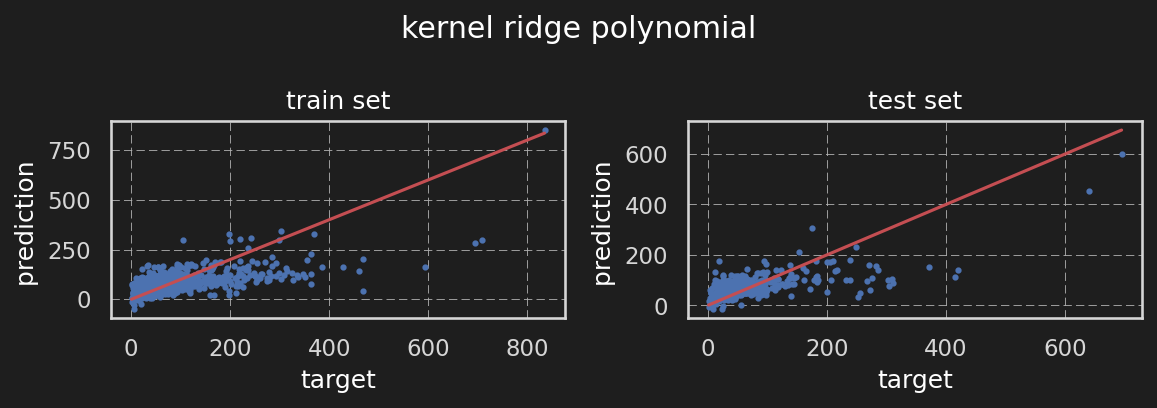

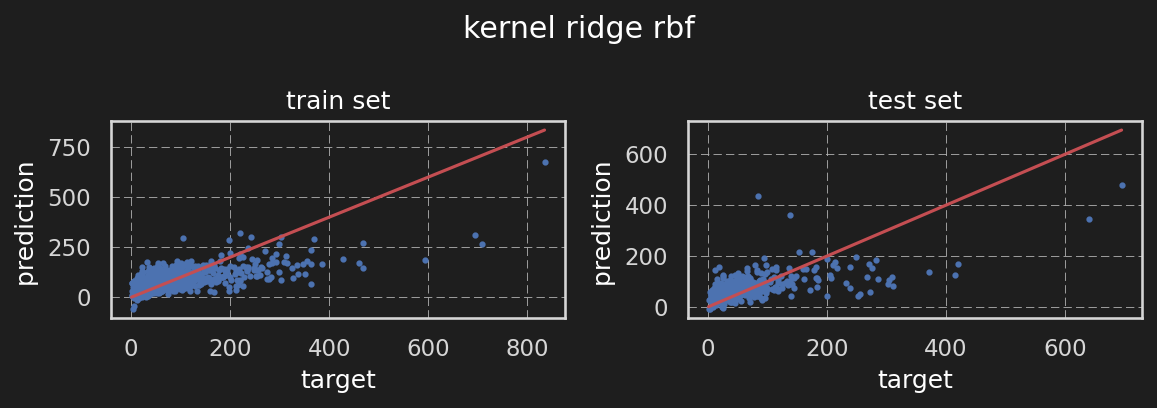

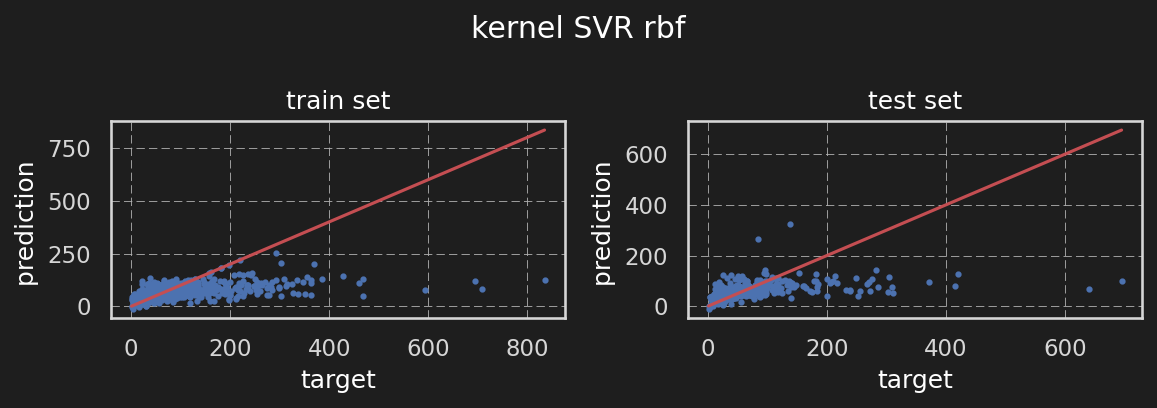

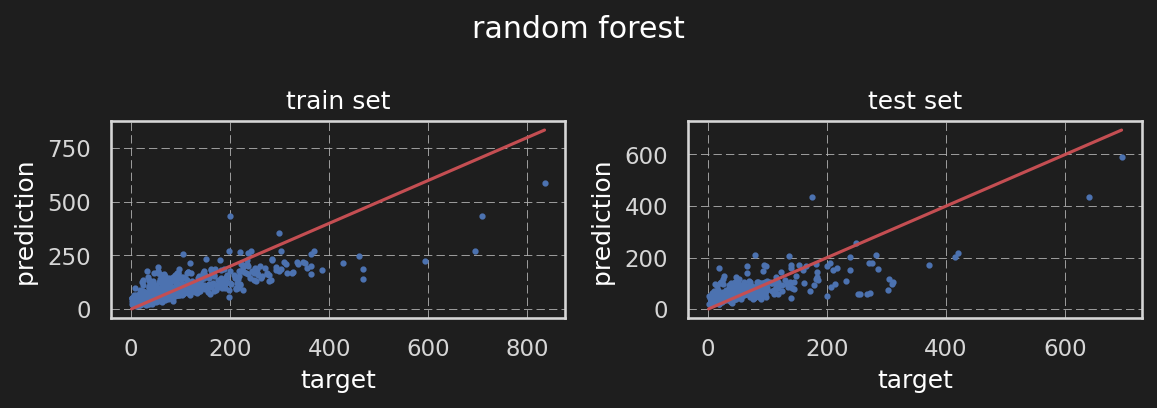

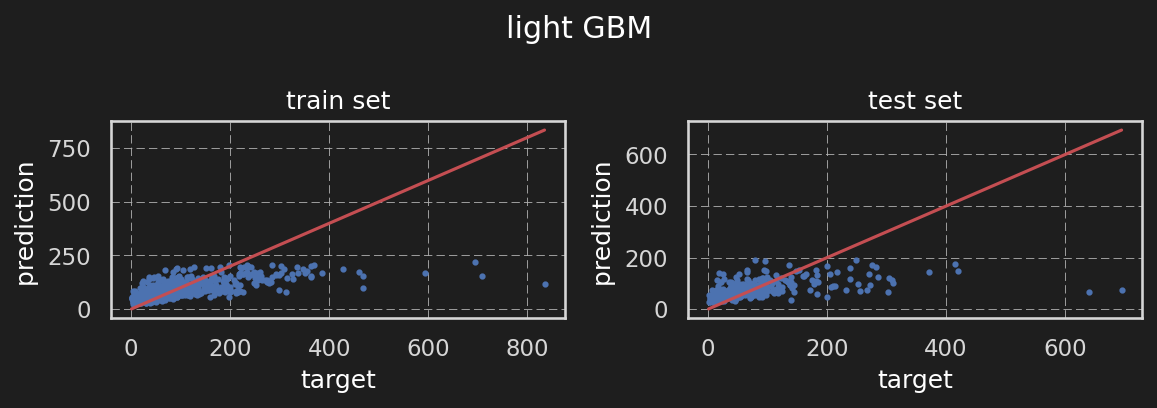

In [233]:
print_y_describe()
print_results( results_0 )

## X scaled

In [236]:
scaler = preprocessing.StandardScaler().fit( X_test )
# scaler = preprocessing.PowerTransformer(method='box-cox' ).fit( X_test )

dico_X = {'train':scaler.transform( X_train ), 'test':scaler.transform( X_test ) }

dico_y = {'train':y_train, 'test':y_test}

results_1 = train_modeles()

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.617e+04, tolerance: 5.677e+02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.340e+05, tolerance: 5.059e+02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Pro

y:


count   mean    std   min    25%    50%    75%     max
raw         train  1161.0  78.22  76.13  0.70  37.50  56.80  87.90  834.40
            test    388.0  76.85  78.66  1.50  34.05  53.65  88.08  694.70
transformed train  1161.0   0.00   0.81 -3.53  -0.41   0.00   0.43    2.67
            test    388.0  -0.05   0.86 -3.14  -0.50  -0.05   0.43    2.49

dummy median  elastic net  linear SVR  \
         training time (sec.)          0.01         3.62        0.34   
RMSE     train                        79.05        58.80       58.62   
         test                         81.07        57.14       57.00   
R2 score train                        -0.08         0.40        0.41   
         test                         -0.07         0.47        0.47   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                     4.50             12.72   
RMSE     train                                   58.49             50.28   
         test                                    56.84             55.47   
R2 score train                                    0.41              0.56   
         test                                     0.48              0.50   

                               kernel SVR rbf  random forest  light GBM  
         training time (sec.)            8.21          52.94      54.95  
RMSE     train                          61.13          45.48      53.86  
         test                           59.76          53.22      68.05  
R2 score train                           0.35           0.64       0.50  
         test                            0.42           0.54       0.25



|--------------------|
Modèle : dummy median
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'strategy': 'median'}


|--------------------|
Modèle : elastic net
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.5455594781168515, 'l1_ratio': 0.9176401255998495}


|--------------------|
Modèle : linear SVR
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 0.01438449888287663, 'loss': 'squared_epsilon_insensitive'}


|--------------------|
Modèle : kernel ridge polynomial
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.01, 'degree': 1}


|--------------------|
Modèle : kernel ridge rbf
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.001291549665014884, 'gamma': 0.0002782559402207126}


|--------------------|
Modèle : kernel SVR rbf
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 10000.0, 'gamma': 0.0001291549665014884}


|--------------------|
Modèle : random forest
Meilleur(s) hyperparamè

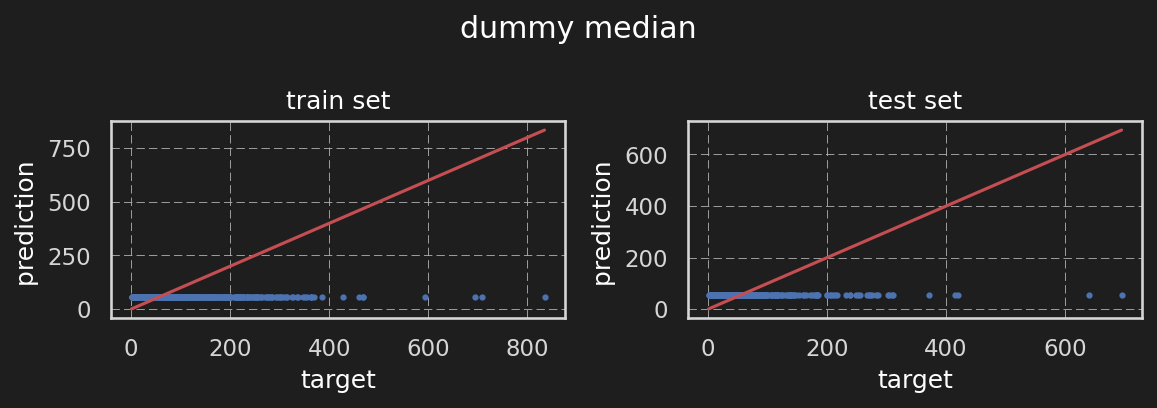

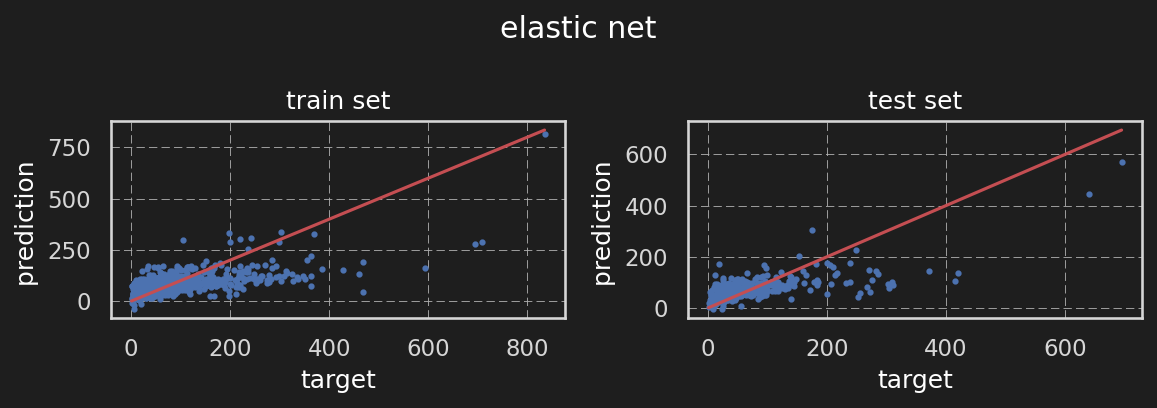

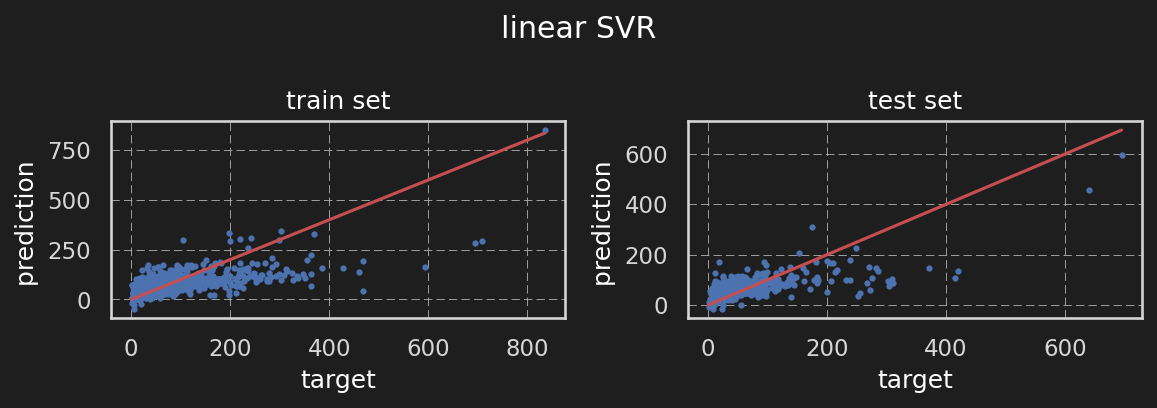

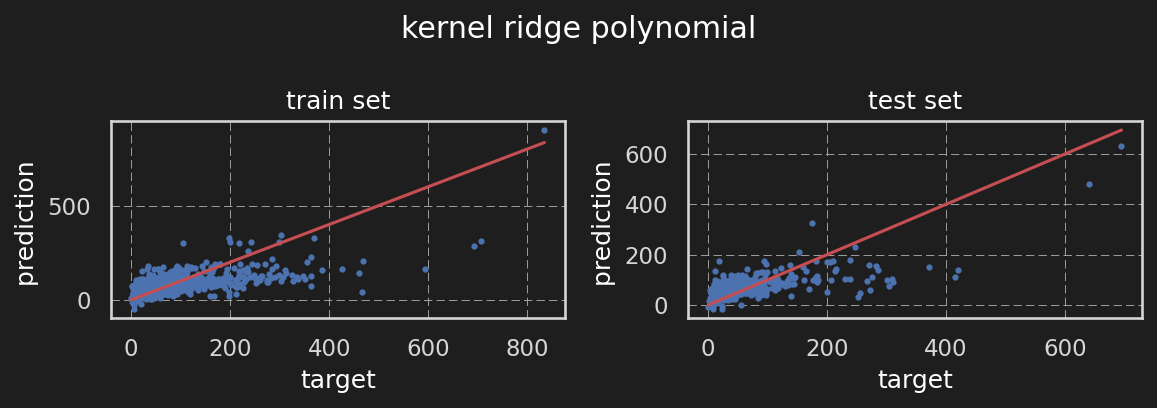

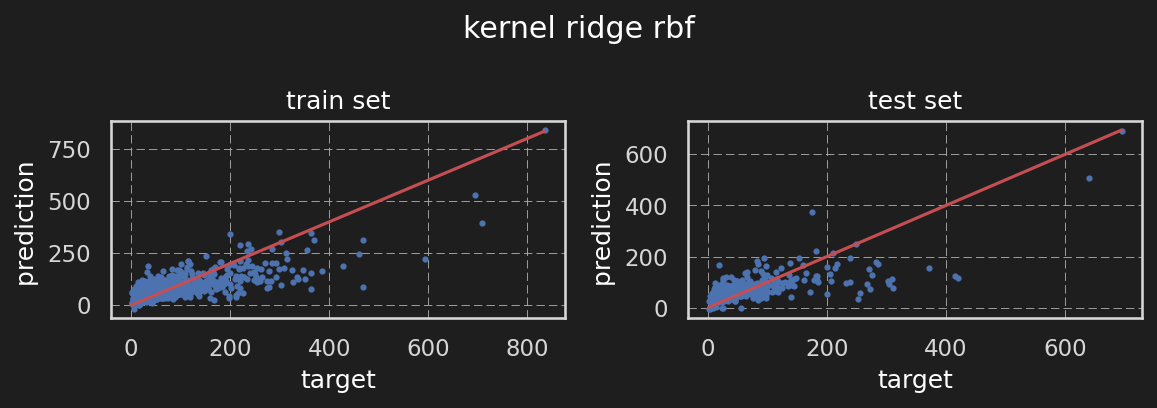

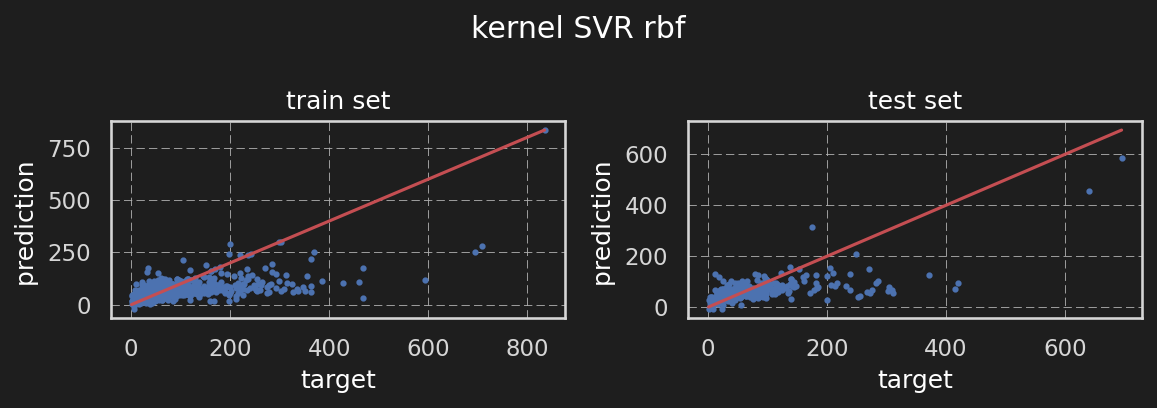

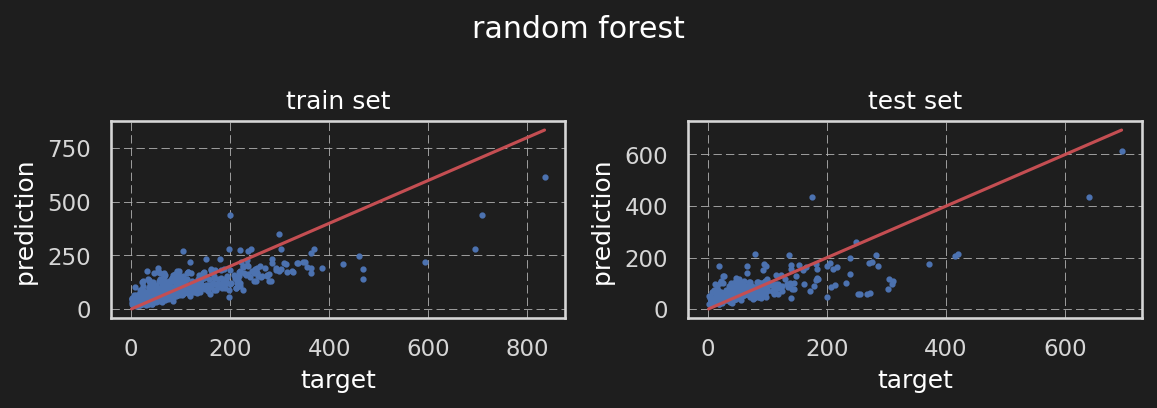

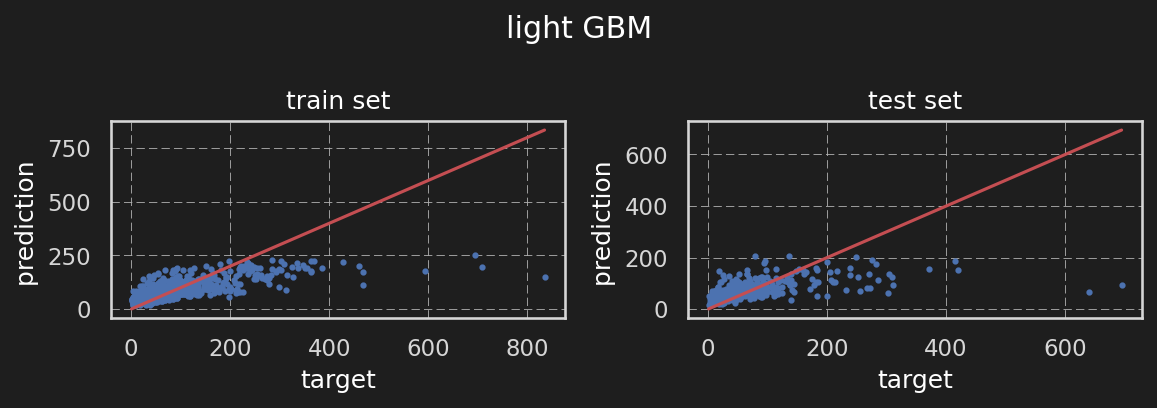

In [237]:
print_y_describe()
print_results( results_1 )

## Y transformed

In [238]:
dico_X = {'train':X_train, 'test':X_test}

transformer = TargetTransformer().fit( y_train )
y_train_transformed = transformer.transform( y_train )
y_test_transformed = transformer.transform( y_test )
dico_y = {'train':y_train_transformed, 'test':y_test_transformed}

results_2 = train_modeles()

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.800e+00, tolerance: 6.128e-02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.112e+00, tolerance: 6.144e-02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Pro

y:


count   mean    std   min    25%    50%    75%     max
raw         train  1161.0  78.22  76.13  0.70  37.50  56.80  87.90  834.40
            test    388.0  76.85  78.66  1.50  34.05  53.65  88.08  694.70
transformed train  1161.0   0.00   0.81 -3.53  -0.41   0.00   0.43    2.67
            test    388.0  -0.05   0.86 -3.14  -0.50  -0.05   0.43    2.49

dummy median  elastic net  linear SVR  \
         training time (sec.)          0.01         1.40        0.38   
RMSE     train                         0.81         0.62        0.62   
         test                          0.86         0.64        0.64   
R2 score train                        -0.00         0.41        0.41   
         test                         -0.00         0.45        0.45   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                     4.47             12.76   
RMSE     train                                    0.53              0.59   
         test                                     0.63              0.66   
R2 score train                                    0.58              0.47   
         test                                     0.47              0.41   

                               kernel SVR rbf  random forest  light GBM  
         training time (sec.)           42.33          51.06      51.99  
RMSE     train                           0.59           0.36       0.56  
         test                            0.66           0.59       0.66  
R2 score train                           0.46           0.80       0.52  
         test                            0.41           0.53       0.40



|--------------------|
Modèle : dummy median
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'strategy': 'median'}


|--------------------|
Modèle : elastic net
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.000379269019073225, 'l1_ratio': 0.5}


|--------------------|
Modèle : linear SVR
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 3.359818286283781, 'loss': 'squared_epsilon_insensitive'}


|--------------------|
Modèle : kernel ridge polynomial
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.01, 'degree': 2}


|--------------------|
Modèle : kernel ridge rbf
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.0001668100537200059, 'gamma': 0.0001}


|--------------------|
Modèle : kernel SVR rbf
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 10000.0, 'gamma': 7.742636826811278e-05}


|--------------------|
Modèle : random forest
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînem

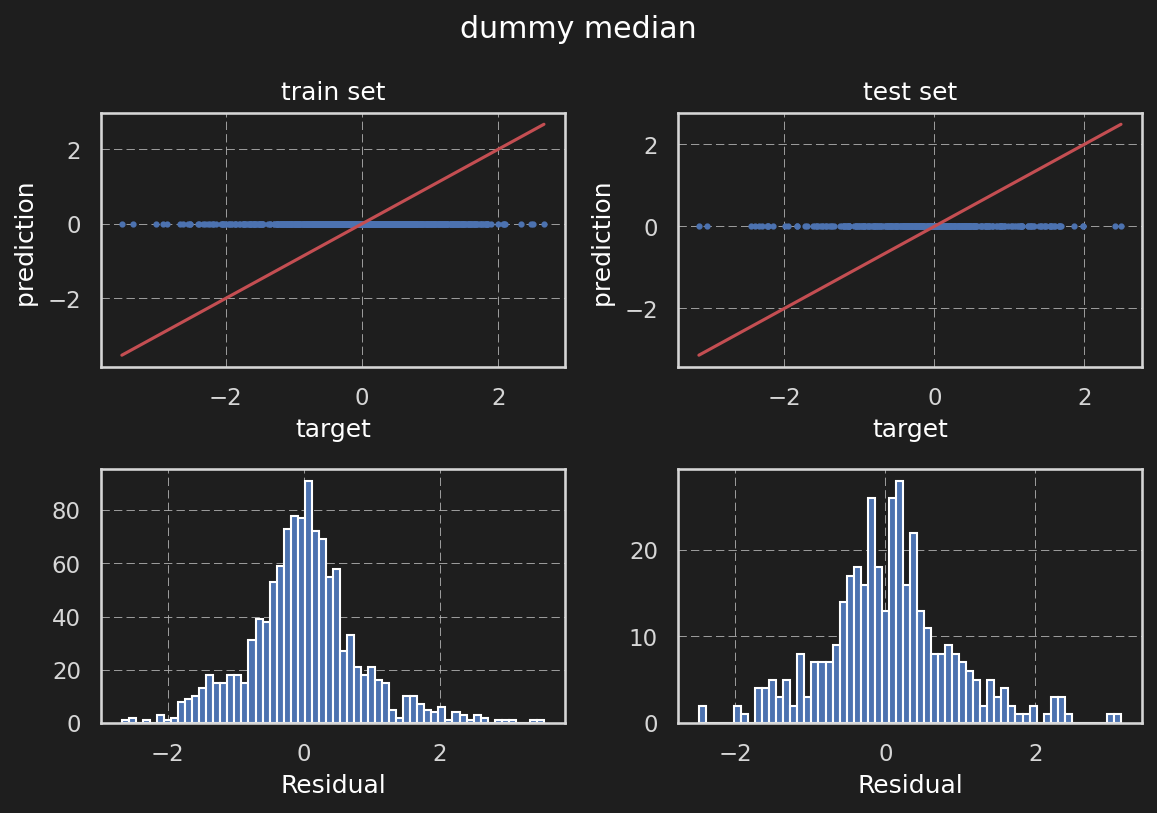

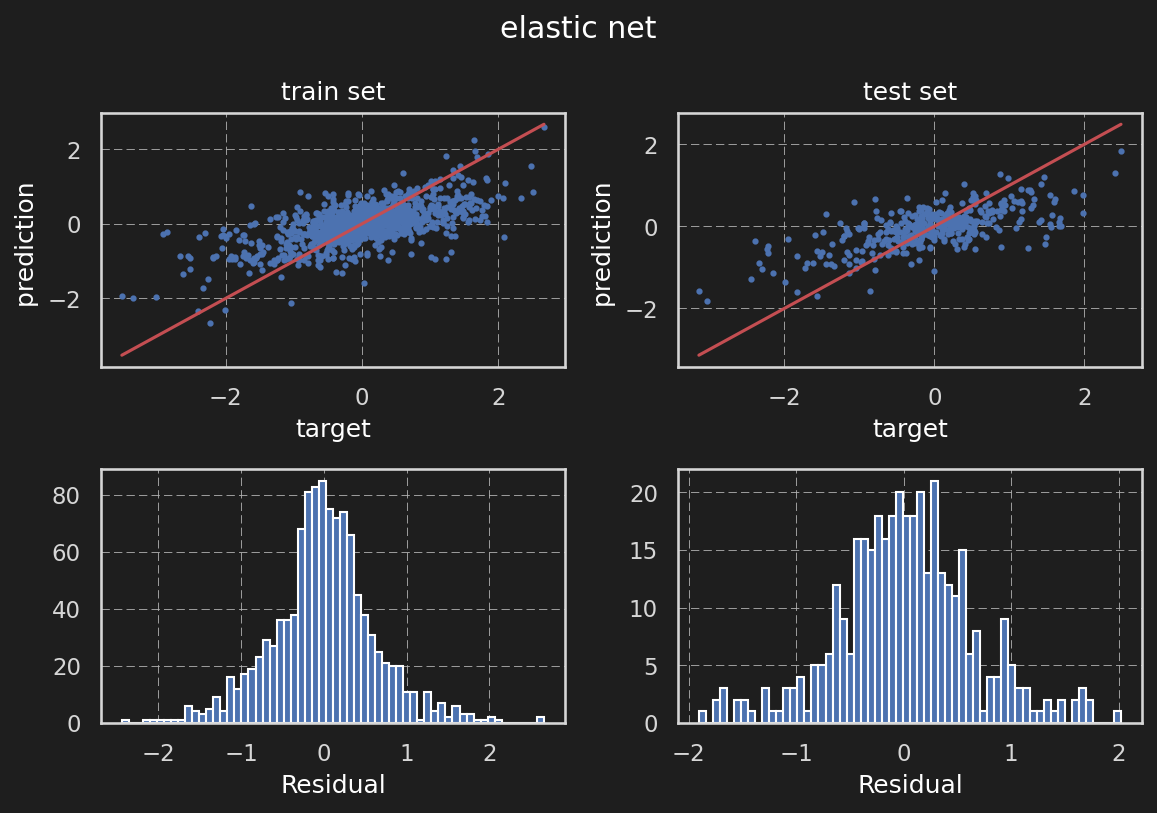

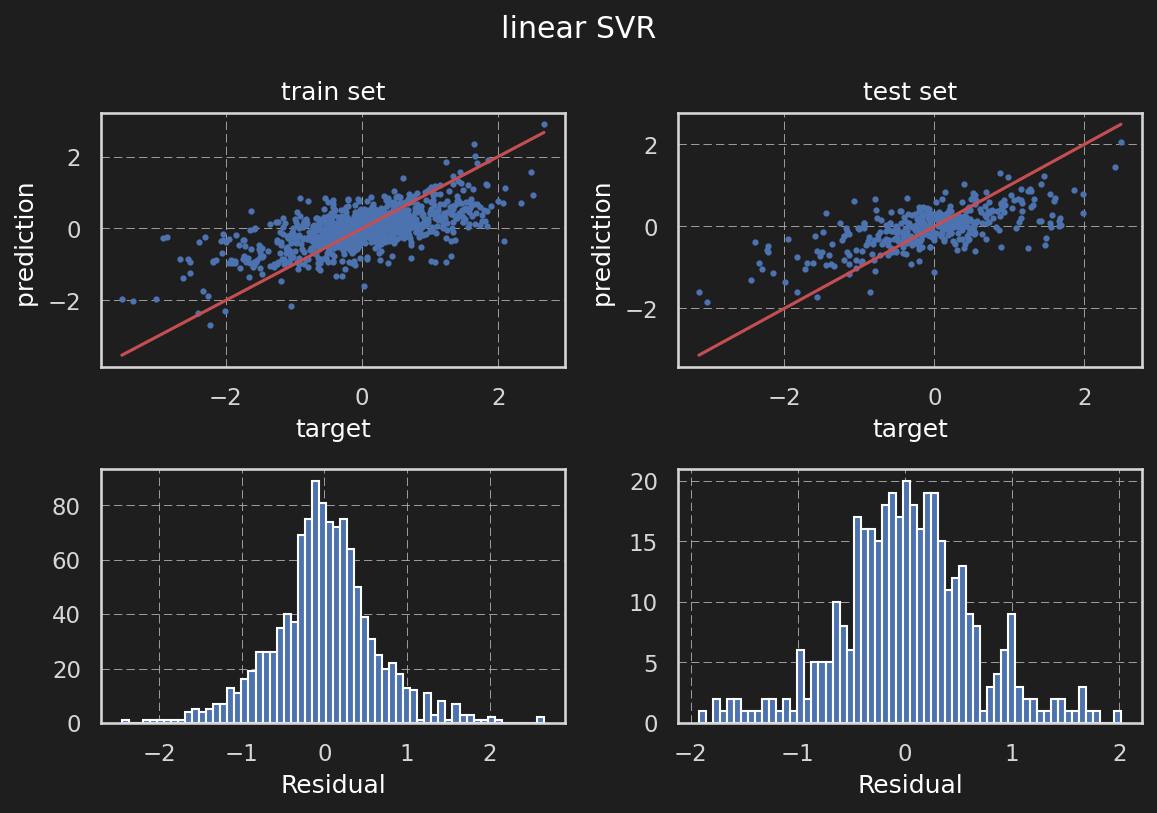

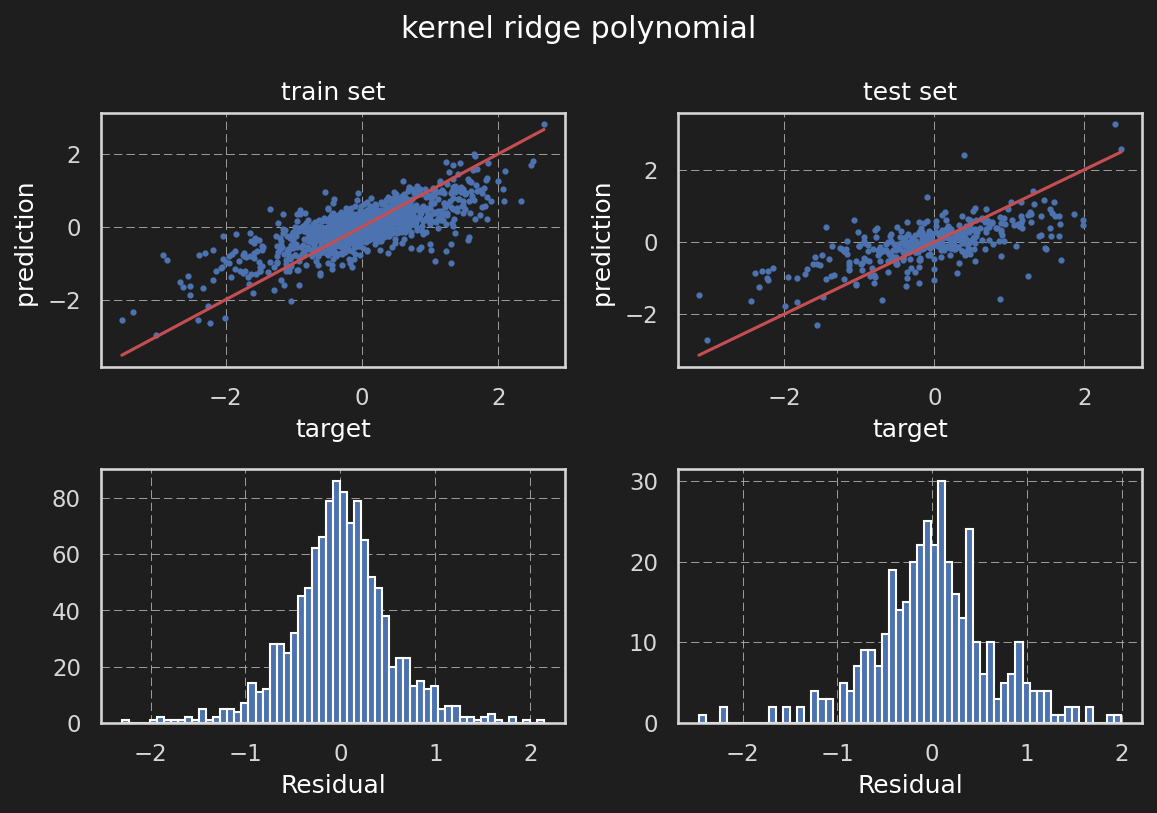

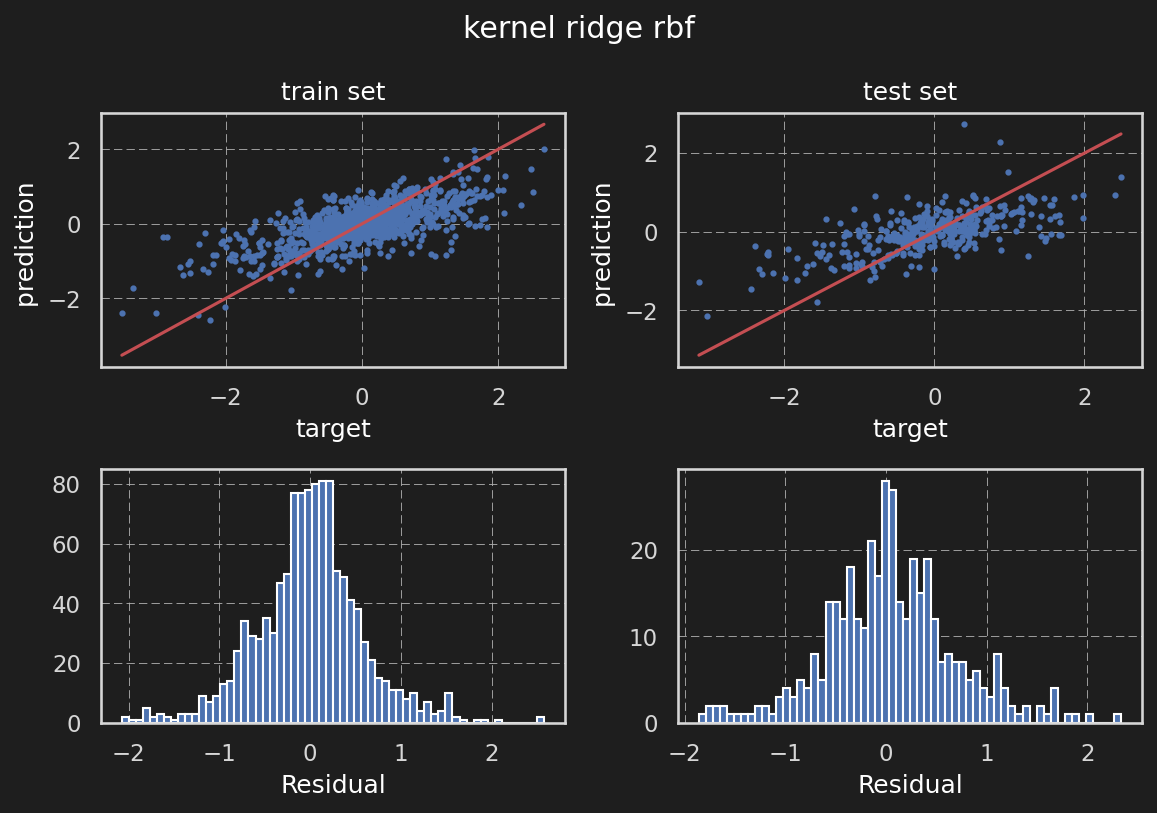

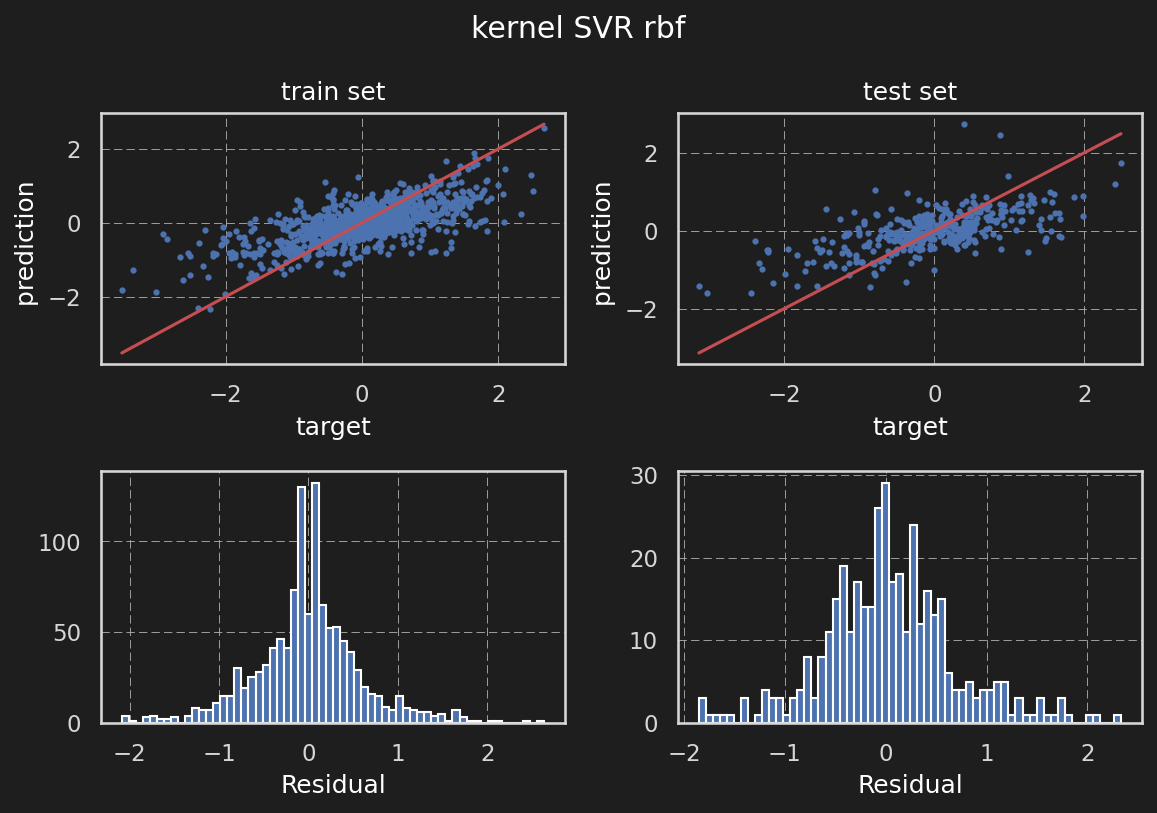

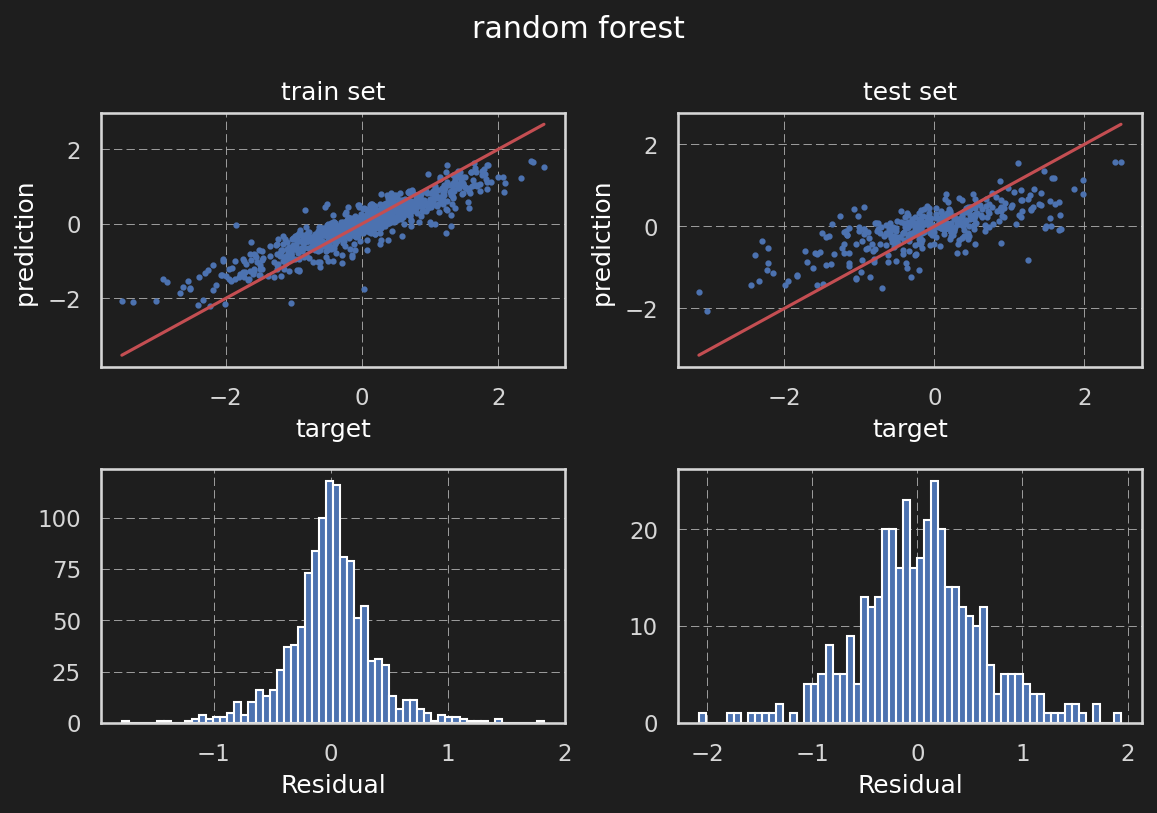

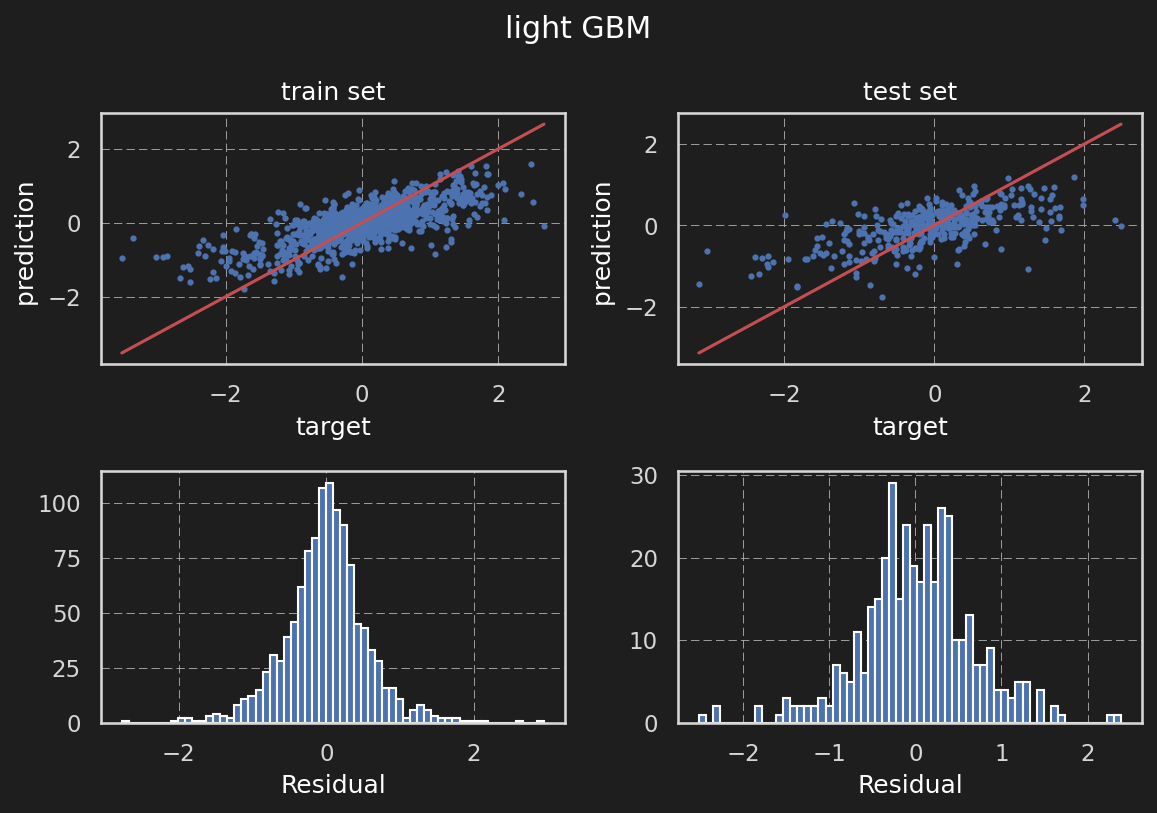

In [241]:
print_y_describe()
print_results( results_2 )

## X scaled and Y transformed

In [242]:
scaler = preprocessing.StandardScaler().fit( X_test )
dico_X = {'train':scaler.transform( X_train ), 'test':scaler.transform( X_test )}


transformer = TargetTransformer().fit( y_train )
y_train_transformed = transformer.transform( y_train )
y_test_transformed = transformer.transform( y_test )
dico_y = {'train':y_train_transformed, 'test':y_test_transformed}


results_3 = train_modeles()

/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.937e+00, tolerance: 6.128e-02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Projetcs/03_energy/.venv/lib64/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.952e+00, tolerance: 6.128e-02
  model = cd_fast.enet_coordinate_descent(
/home/thomas/Documents/Formations/OpenClassRooms/OC-formation-Ingenieur-Machine-Learning/Pro

y:


count   mean    std   min    25%    50%    75%     max
raw         train  1161.0  78.22  76.13  0.70  37.50  56.80  87.90  834.40
            test    388.0  76.85  78.66  1.50  34.05  53.65  88.08  694.70
transformed train  1161.0   0.00   0.81 -3.53  -0.41   0.00   0.43    2.67
            test    388.0  -0.05   0.86 -3.14  -0.50  -0.05   0.43    2.49

dummy median  elastic net  linear SVR  \
         training time (sec.)          0.01         1.85        0.33   
RMSE     train                         0.81         0.63        0.63   
         test                          0.86         0.64        0.64   
R2 score train                        -0.00         0.40        0.41   
         test                         -0.00         0.45        0.45   

                               kernel ridge polynomial  kernel ridge rbf  \
         training time (sec.)                     4.56             12.82   
RMSE     train                                    0.62              0.53   
         test                                     0.64              0.60   
R2 score train                                    0.41              0.58   
         test                                     0.45              0.52   

                               kernel SVR rbf  random forest  light GBM  
         training time (sec.)           21.36          53.75      62.28  
RMSE     train                           0.55           0.36       0.57  
         test                            0.61           0.59       0.67  
R2 score train                           0.53           0.80       0.51  
         test                            0.49           0.53       0.40



|--------------------|
Modèle : dummy median
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'strategy': 'median'}


|--------------------|
Modèle : elastic net
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.01438449888287663, 'l1_ratio': 0.9176401255998495}


|--------------------|
Modèle : linear SVR
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 0.01438449888287663, 'loss': 'squared_epsilon_insensitive'}


|--------------------|
Modèle : kernel ridge polynomial
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.01, 'degree': 1}


|--------------------|
Modèle : kernel ridge rbf
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.01, 'gamma': 0.001291549665014884}


|--------------------|
Modèle : kernel SVR rbf
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 1291.5496650148827, 'gamma': 0.00021544346900318823}


|--------------------|
Modèle : random forest
Meilleur(s) hyperparamètre(

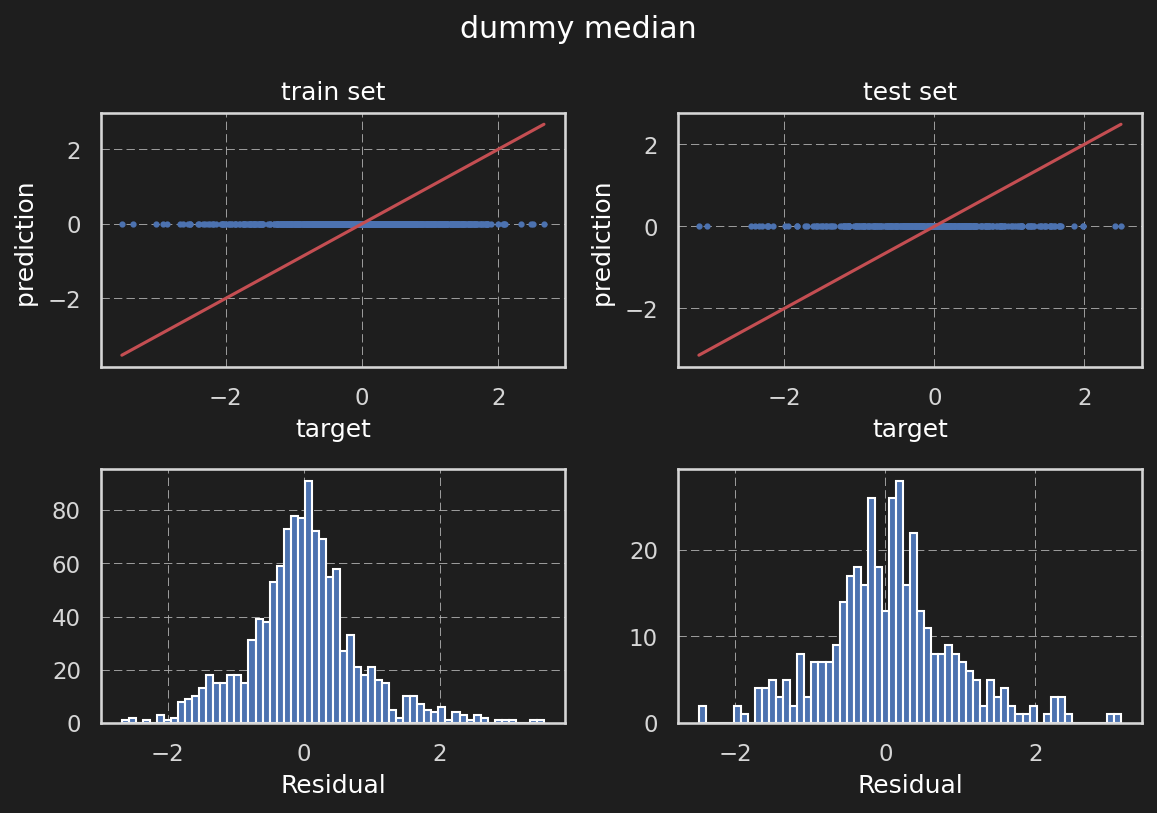

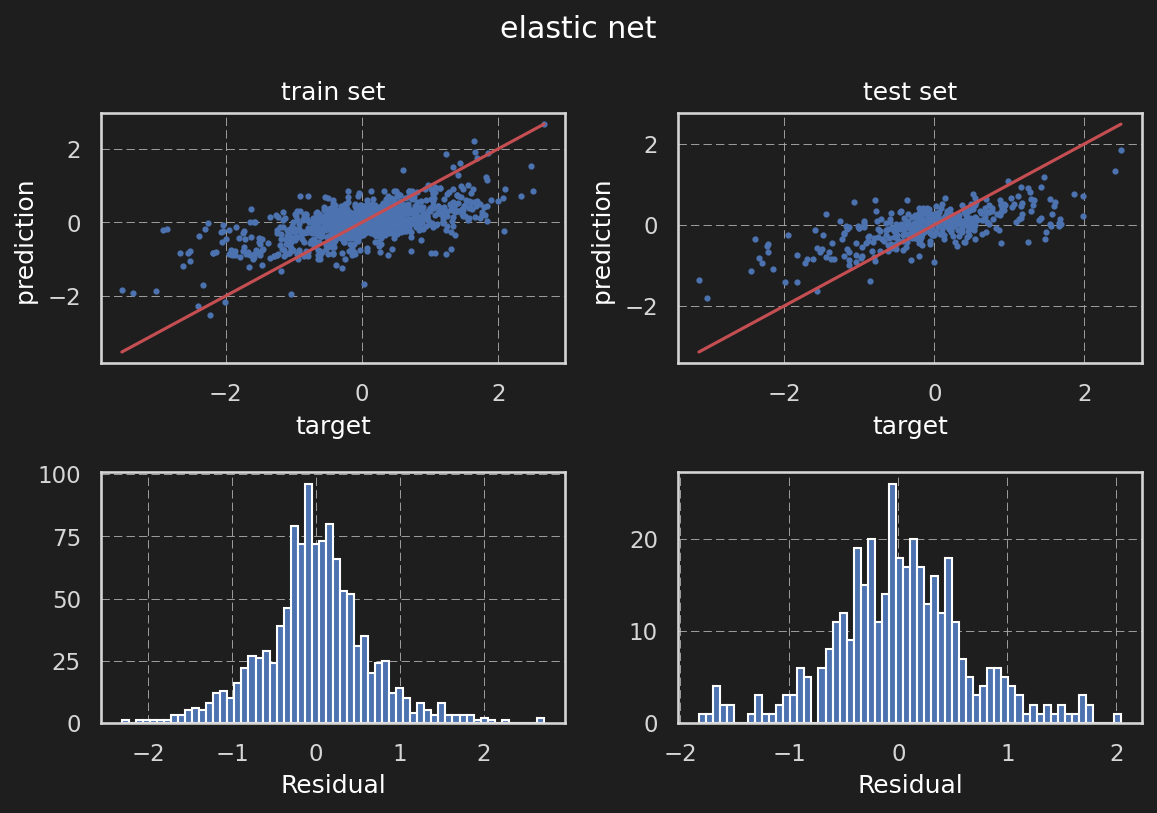

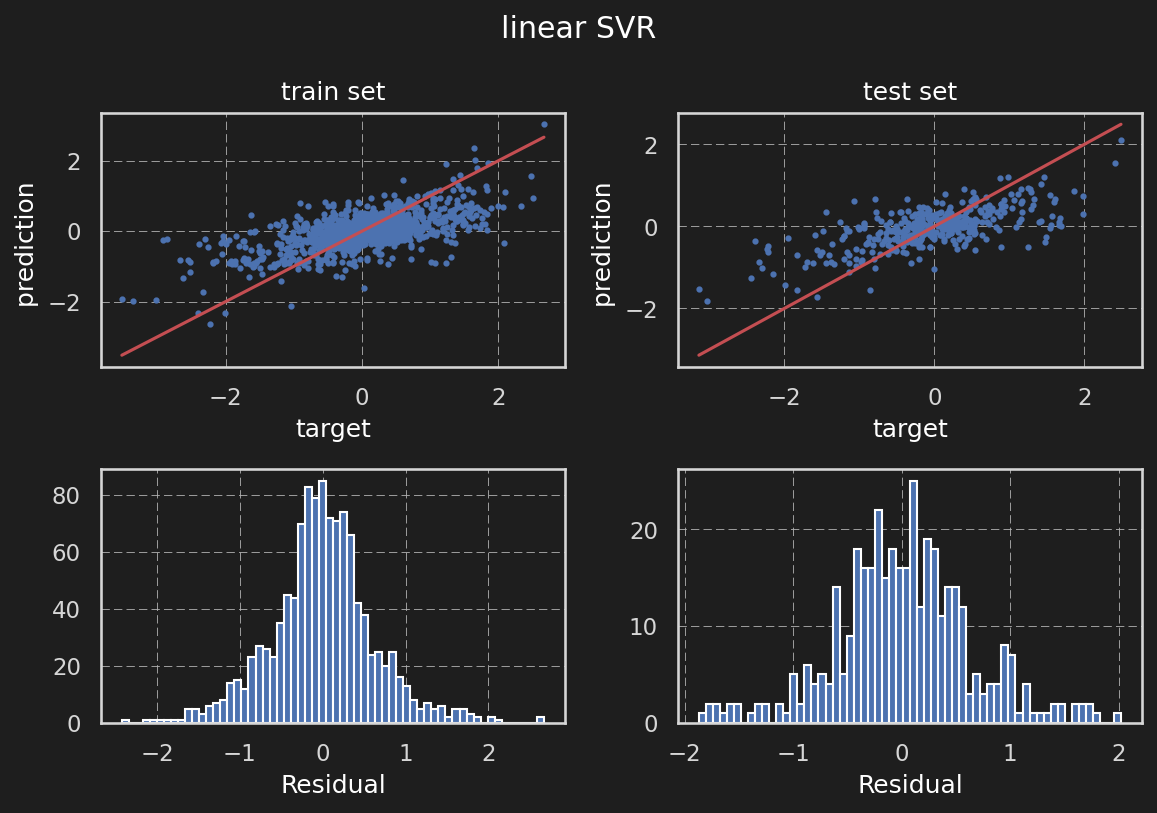

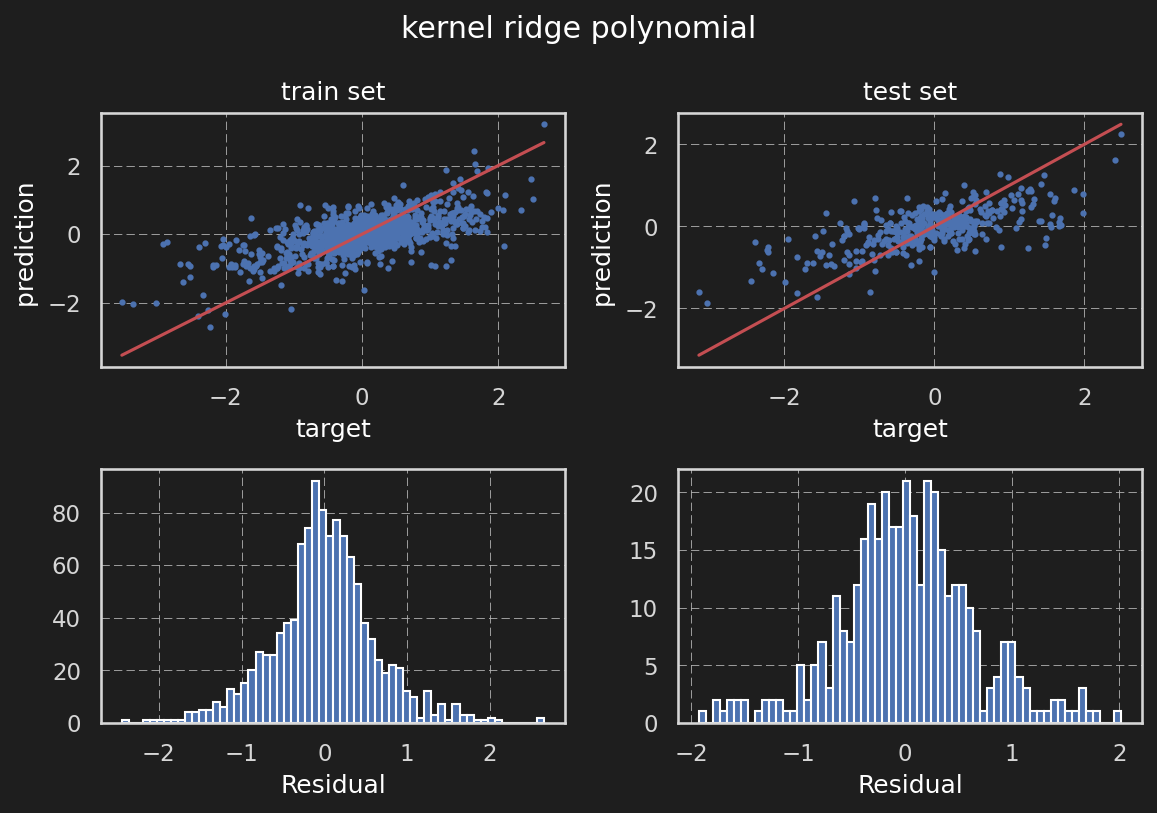

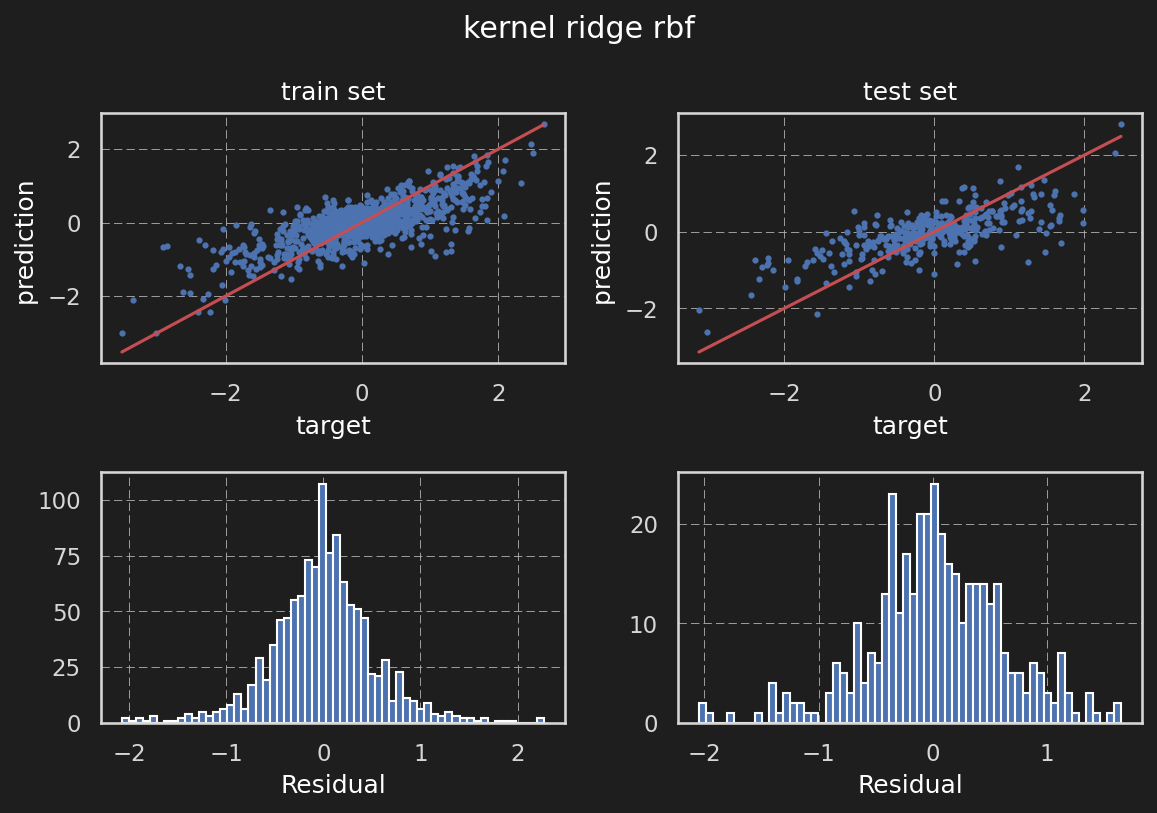

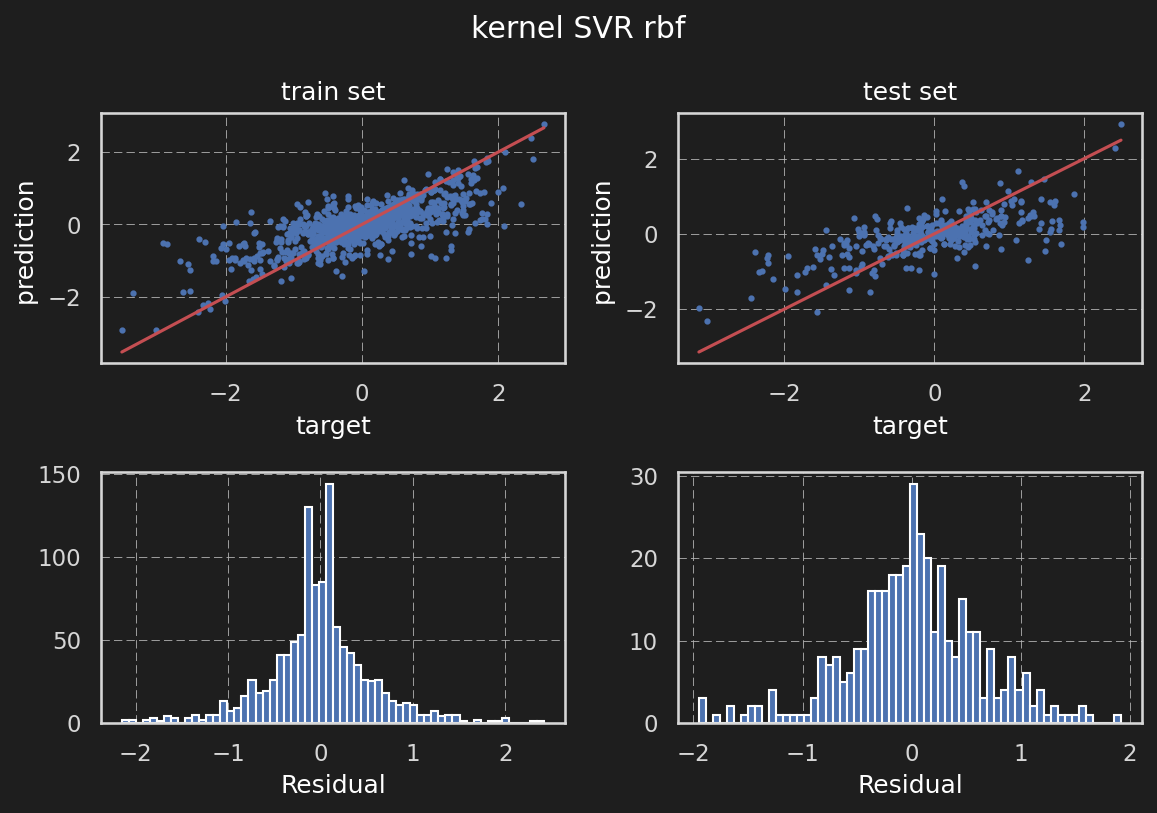

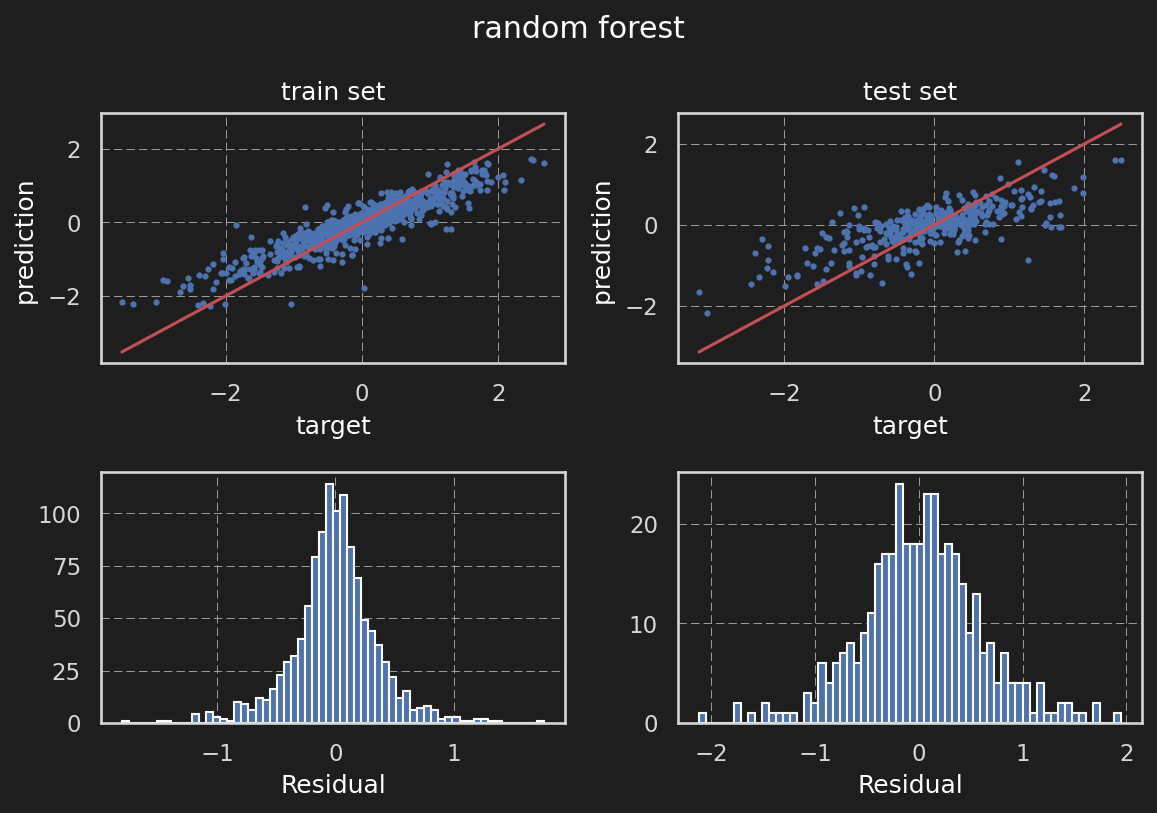

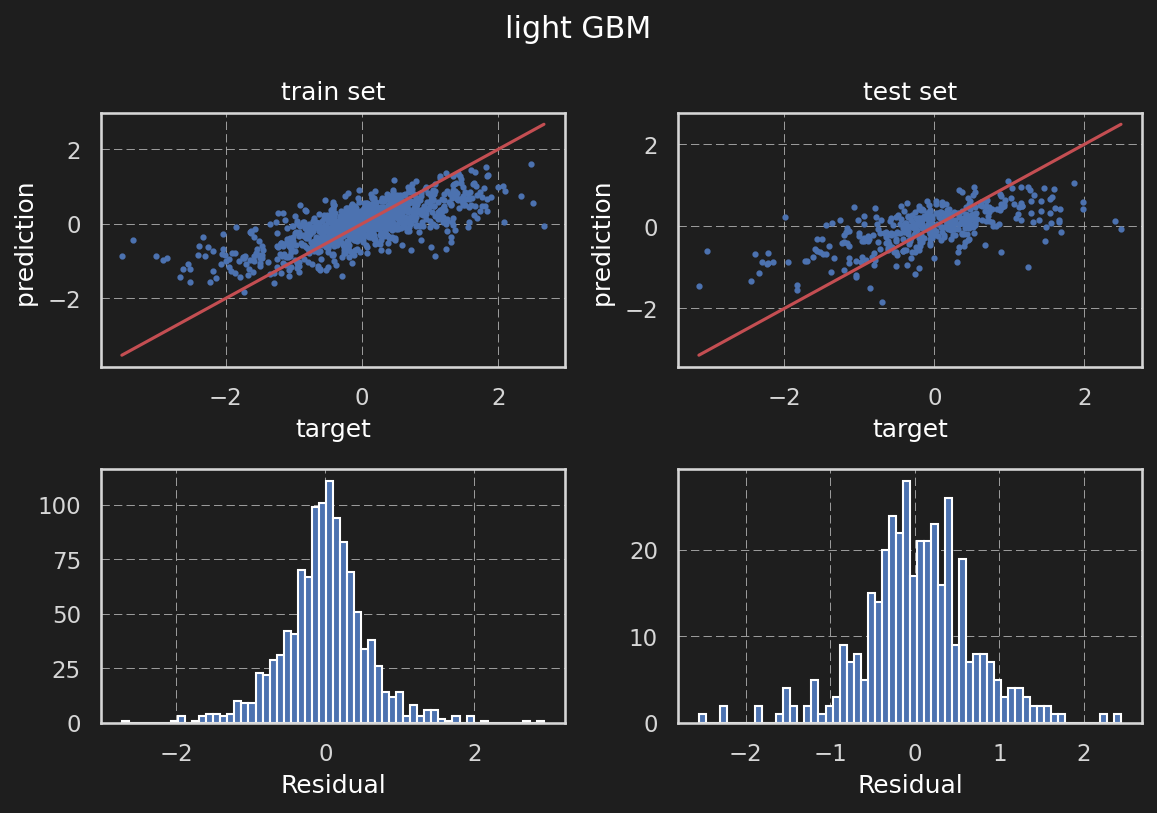

In [243]:
print_y_describe()

print_results( results_3 )